In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import os

In [32]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [33]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [34]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [35]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [36]:
# View all of the classes that automap found
# Get all the class names
class_names = Base.classes.keys()

# Print the class names
for class_name in class_names:
    print(class_name)

measurement
station


In [37]:
# Save references to the classes
Station = Base.classes.station
Measurement = Base.classes.measurement

In [38]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [39]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

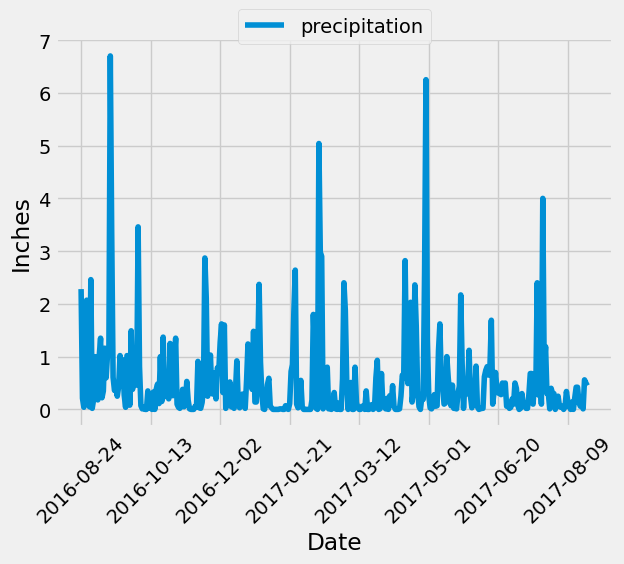

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
year_results = (session.query(Measurement.date, func.max(Measurement.prcp))
                 .filter(func.strftime('%Y-%m-%d', Measurement.date) > one_year_ago)
                 .group_by(Measurement.date)
                 .all())
# Save the query results as a Pandas DataFrame. Explicitly set the column names
pcrp_df = pd.DataFrame(year_results, columns=['date', 'precipitation'])
pcrp_df.set_index('date', inplace=True)

# Sort the dataframe by date
pcrp_df.sort_values('date')

#plot the results of the query
pcrp_df.plot().set(xlabel='Date', ylabel='Inches')
plt.xticks(rotation=45)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=1)
plt.show()

In [51]:
# Save the plot as a JPEG image in the "images" folder
folder_name = "Images"
os.makedirs(folder_name, exist_ok=True)  # Create the folder if it doesn't exist
file_path = os.path.join(folder_name, "pcrp_plot.png")
plt.savefig(file_path, format='png')

<Figure size 640x480 with 0 Axes>

In [52]:
# Use Pandas to calculate the summary statistics for the precipitation data
stats_df = pd.DataFrame(pcrp_df['precipitation'].describe())
stats_df

,precipitation
count,365.000000
mean,0.517288
std,0.829196
min,0.000000
25%,0.040000
50%,0.250000
75%,0.650000
max,6.700000


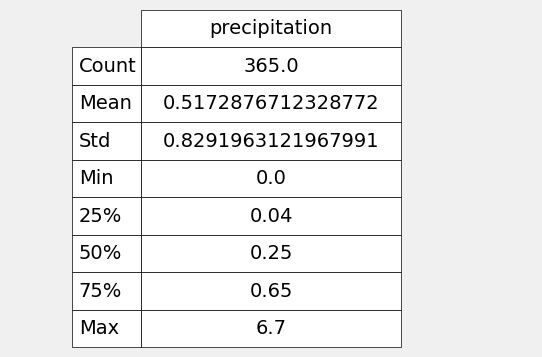

In [53]:
# Create a table visualization
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust the figsize according to your preference
ax.axis('off')  # Turn off axis for a cleaner table

# Add row header
row_labels = ['Count', 'Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max']
table = plt.table(cellText=stats_df.values, colLabels=stats_df.columns, rowLabels=row_labels,
                  cellLoc='center', loc='center')

table.set_fontsize(14)  # Set the font size of the table
table.scale(1, 1.5)  # Adjust the scale of the table to fit the data

# Adjust row heights
table.auto_set_column_width([0, 1])  # Auto-adjust column width
table.auto_set_font_size(False)  # Disable automatic font size adjustment
table.set_fontsize(14)  # Set the font size of the table
table.scale(1, 1.5)  # Adjust the scale of the table to fit the data
table_props = table.properties()
table_cells = table_props['celld']


# Save the table as a JPEG image in the "images" folder
folder_name = "Images"
os.makedirs(folder_name, exist_ok=True)  # Create the folder if it doesn't exist
file_path = os.path.join(folder_name, "stats_table.png")
plt.savefig(file_path, bbox_inches='tight', pad_inches=0.5, format='png')


# Exploratory Station Analysis

In [54]:
# Design a query to calculate the total number of stations in the dataset
station_number = session.query(Station.station).count()
station_number

9

In [55]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations=session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [56]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Retrieve the most active station ID from the previous query result
most_active_station = active_stations[0][0] 

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)) \
                           .filter(Measurement.station == most_active_station) \
                           .all()

lowest_temp = temperature_stats[0][0]
highest_temp = temperature_stats[0][1]
avg_temp = temperature_stats[0][2]

lowest_temp, highest_temp, avg_temp

(54.0, 85.0, 71.66378066378067)

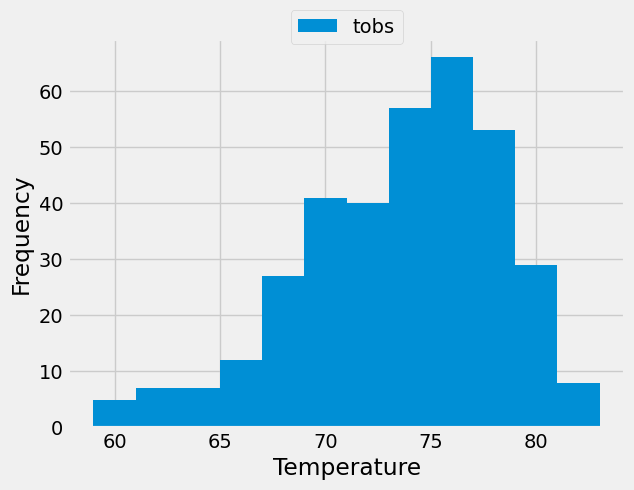

In [57]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs) \
                          .filter(Measurement.station == most_active_station) \
                          .filter(Measurement.date >= one_year_ago) \
                          .all()

# Convert the query result to a DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['tobs'])

# Plot the temperature data as a histogram
temperature_df.plot(kind='hist', bins=12).set(xlabel='Temperature', ylabel='Frequency')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=1)
plt.show()

# Close Session

In [58]:
# Save the plot as a JPEG image in the "images" folder
folder_name = "Images"
os.makedirs(folder_name, exist_ok=True)  # Create the folder if it doesn't exist
file_path = os.path.join(folder_name, "station_plot.png")
plt.savefig(file_path, format='png')

<Figure size 640x480 with 0 Axes>

In [49]:
# Close Session
session.close()